# Vorhersage des Optimalen Düngers
Basierend auf den von Kaggel bereit gestellten Daten sollen die besten Dünger vorhergesagt werden:

### Import Libraries:

In [11]:
#Libraries & Tools:
#Anaconda:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

### Data import:

In [ ]:
#Data
df = pd.read_csv("train.csv")

# Check for missing values
#print(df.isnull().sum())
# Drop rows with missing values
#df = df.dropna()


#Output:
print('Complete Table:')
df.head(5)

### Define and Transform the Target: y

In [2]:
target = "Fertilizer Name"
target_le = LabelEncoder()

y = target_le.fit_transform(df[target])

# print( df[target].unique() +"\n")
for i, label in enumerate(target_le.classes_): print(f"{i} -> {label}")

0 -> 10-26-26
1 -> 14-35-14
2 -> 17-17-17
3 -> 20-20
4 -> 28-28
5 -> DAP
6 -> Urea


### Define and Transform Features:

In [3]:
print("Table before transformation:")
print(df.drop(columns=["id", target]).head(5).to_string(index=False))


# Remove id and target ("Fertilizer Name") from the Features 
features = df.drop(columns=["id", target])

# Find columns with text instead of numbers
columns_with_names = features.select_dtypes(include="object").columns

# Kategorische Features encodieren
label_encoders = {}
for column in columns_with_names:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column])
    label_encoders[column] = le


print("Table with transformed features:")
print(features.head(5).to_string(index=False))

print("\nLabelEncoder mappings:\n")
for i, (col_name, le) in enumerate(label_encoders.items()):
    print(f"{i+1}. Column: '{col_name}'")
    for j ,class_name in enumerate(le.classes_):
        print(f"{j:>2} → {class_name}")                         #:>2 fügt eine Leerzeile vor einstelligen Zahlen hinzu
    print()

Table before transformation:
 Temparature  Humidity  Moisture Soil Type Crop Type  Nitrogen  Potassium  Phosphorous
          37        70        36    Clayey Sugarcane        36          4            5
          27        69        65     Sandy   Millets        30          6           18
          29        63        32     Sandy   Millets        24         12           16
          35        62        54     Sandy    Barley        39         12            4
          35        58        43       Red     Paddy        37          2           16
Table with transformed features:
 Temparature  Humidity  Moisture  Soil Type  Crop Type  Nitrogen  Potassium  Phosphorous
          37        70        36          1          8        36          4            5
          27        69        65          4          4        30          6           18
          29        63        32          4          4        24         12           16
          35        62        54          4          0      

In [7]:
def create_features(df):
    df['soil_crop'] = df['Soil Type'].astype(str) + '_' + df['Crop Type'].astype(str)
    df['npk_total'] = df['Nitrogen'] + df['Phosphorous'] + df['Potassium']
    df['npk_ratio'] = df['npk_total'] / (df['Moisture'] + 1)
    df['temp_hum_ratio'] = df['Temparature'] / (df['Humidity'] + 1)
    df['is_high_nitro'] = (df['Nitrogen'] > 60).astype(int)
    
    for col in ['Soil Type', 'Crop Type', 'soil_crop']:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

features = create_features(features)

print(features.head(5).to_string(index=False))

 Temparature  Humidity  Moisture  Soil Type  Crop Type  Nitrogen  Potassium  Phosphorous  soil_crop  npk_total  npk_ratio  temp_hum_ratio  is_high_nitro
          37        70        36          1          8        36          4            5         20         45   1.216216        0.521127              0
          27        69        65          4          4        30          6           18         49         54   0.818182        0.385714              0
          29        63        32          4          4        24         12           16         49         52   1.575758        0.453125              0
          35        62        54          4          0        39         12            4         44         55   1.000000        0.555556              0
          35        58        43          3          6        37          2           16         40         55   1.250000        0.593220              0


### Train-Test-Split:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost
import sklearn

print("xgboost version:", xgboost.__version__)
print("scikit-learn version:", sklearn.__version__)

#xgboost version: 2.1.1
#scikit-learn version: 1.6.1

#conda install scikit-learn=1.3 -> FAILED

#conda install -c conda-forge xgboost=2.1.4
#xgboost version: 2.1.4
#scikit-learn version: 1.6.1


xgboost version: 2.1.4
scikit-learn version: 1.6.1


### Train Modell:

In [6]:
#model = RandomForestClassifier(n_estimators=100, random_state=42)

# Ensure there are no missing values and data types are numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Now convert to DMatrix format
#dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
#dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)


#learning_objective = {
#    'objective': 'multi:softmax',
#    'num_class': len(np.unique(y))
#}
#model = xgb.train(params=learning_objective, dtrain=dmatrix_train)

model = XGBClassifier(objective="multi:softprob", num_class=len(np.unique(y)))
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

### Prediction and Evaluation:

In [7]:
y_pred = model.predict(X_test)

<Figure size 1200x800 with 0 Axes>

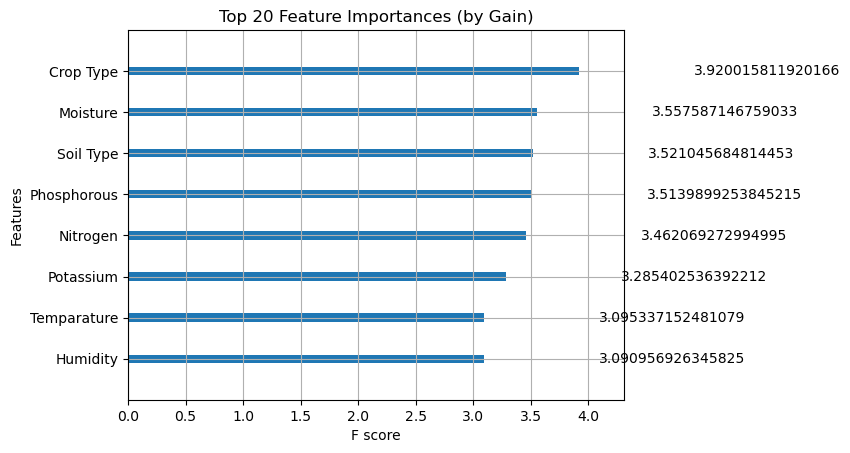

In [12]:
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=20, importance_type='gain')  # gain = nützlichste Metrik
plt.title("Top 20 Feature Importances (by Gain)")
plt.show()

Accuracy: 0.195


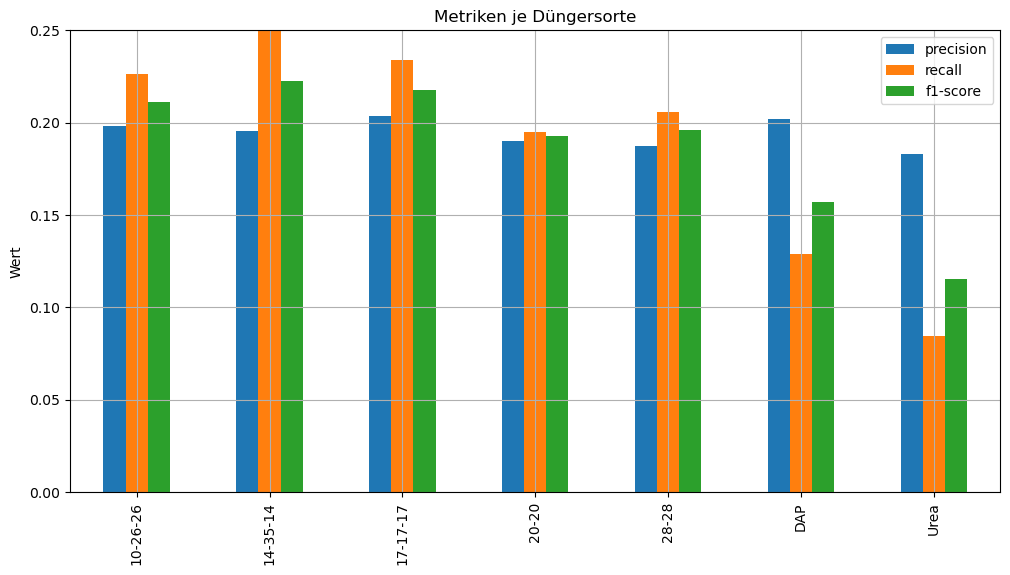

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred, target_names=target_le.classes_))

report = classification_report(y_test, y_pred, target_names=target_le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:-3][["precision", "recall", "f1-score"]].plot(kind="bar", figsize=(12,6))
plt.title("Metriken je Düngersorte")
plt.ylabel("Wert")
plt.ylim(0, 0.25)
plt.grid(True)
plt.show()

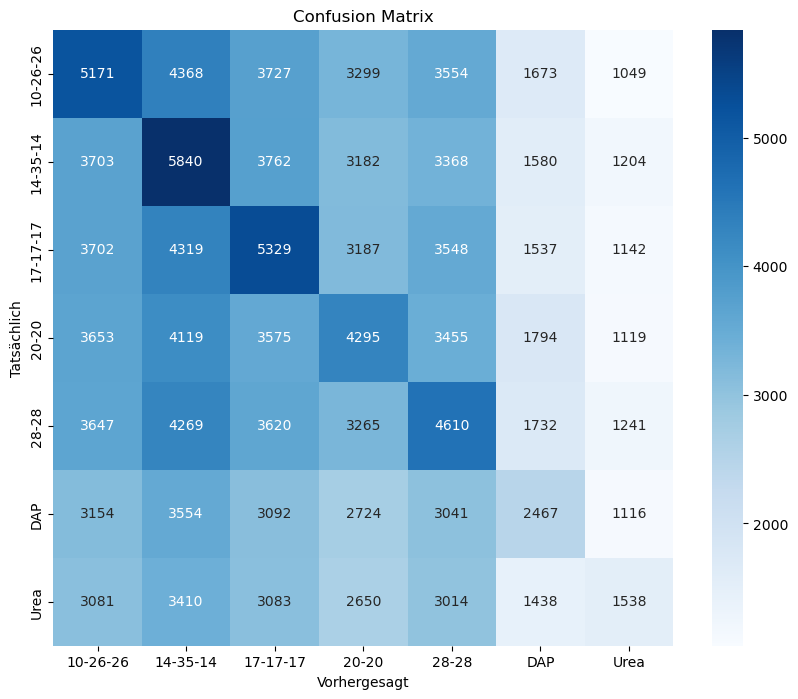

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_le.classes_, yticklabels=target_le.classes_, cmap="Blues")
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix")
plt.show()


## Quellen:
[Yunaki Kuchi's Code on Kaggle](https://www.kaggle.com/code/yunakikuchi/lastd)<br>
[ChatGTP RandomForrest](https://chatgpt.com/s/t_6887ad1370ec8191b03715c28def00c4)<br>
[XGBoost Tuturial](https://www.tutorialspoint.com/xgboost/xgboost-python-implementation.htm)
